# Plant Pathology 2020 - FGVC7
用 PyTorch 與預訓練模型進行植物病害影像分類



## 1. 安裝與環境準備
執行以下指令安裝 Kaggle CLI、timm（含多種影像預訓練模型）、albumentations（資料增強）、scikit-learn（評估指標）及其他套件。

> **注意：** 若已在相容的 Conda / venv 環境中安裝對應版本，視情況略過或調整版本號。

In [ ]:
!pip install -q kaggle timm albumentations==1.4.8 scikit-learn==1.6.1 torchmetrics --upgrade



1.如果你已經手動下載資料，且只想跑 Notebook：
pip install timm albumentations scikit-learn

2.如果想留下預設版本鎖定以確保可重現：
pip install timm==0.9.12 albumentations==1.4.8 scikit-learn==1.6.1 torchmetrics==1.3.2



In [ ]:
import torch, platform, os
print("PyTorch:", torch.__version__)
print("CUDA 可用？", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



PyTorch: 2.5.1+cu121
CUDA 可用？ True
GPU: NVIDIA GeForce RTX 4070 SUPER


In [ ]:
import os, subprocess, zipfile, shutil, glob, pathlib, json, sys, warnings

## 2. 下載資料集

### 2.1 本地壓縮檔解壓縮
若已將 `plant-pathology-2020-fgvc7.zip` 下載至 `./data/` 資料夾，以下程式將自動尋找並解壓縮

In [ ]:
import glob, zipfile, os, pathlib, shutil
DATA_DIR = pathlib.Path('./data')
DATA_DIR.mkdir(exist_ok=True)

# 搜尋單一 zip（或多個）並解壓縮
for z_path in DATA_DIR.glob('*.zip'):
    print(f"解壓縮 {z_path} ...")
    with zipfile.ZipFile(z_path, 'r') as zf:
        zf.extractall(DATA_DIR)
print("解壓縮完成")


解壓縮 data\plant-pathology-2020-fgvc7.zip ...
解壓縮完成


## 3. 資料探索 (EDA)

image_id              object
healthy              float32
multiple_diseases    float32
rust                 float32
scab                 float32
dtype: object
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0      0.0                0.0   0.0   1.0
1  Train_1      0.0                1.0   0.0   0.0
2  Train_2      1.0                0.0   0.0   0.0
3  Train_3      0.0                0.0   1.0   0.0
4  Train_4      1.0                0.0   0.0   0.0


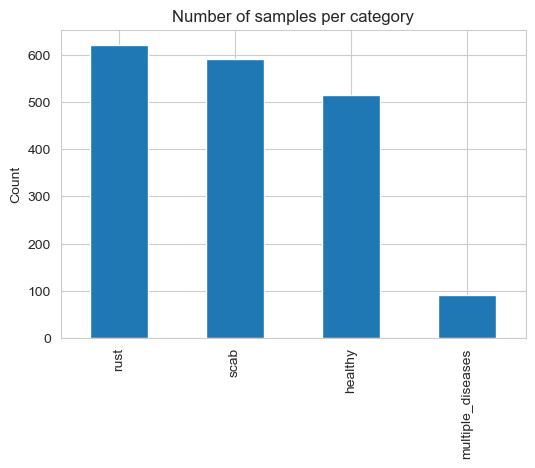

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_style('whitegrid')

train_df = pd.read_csv('./data/train.csv')
# 定義標籤欄位的名稱
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
# 轉成 float32，保證不是 object
train_df[label_cols] = train_df[label_cols].astype('float32')



# 印出欄位型態和前 5 筆資料
print(train_df.dtypes)
print(train_df.head())

# 查看每個類別的影像計數
counts = train_df[label_cols].sum().sort_values(ascending=False)
counts.plot(kind='bar', figsize=(6,4), title='Number of samples per category')
plt.ylabel('Count')
plt.show()


## 4. 資料分割 (Train / Validation)
使用 **StratifiedKFold** 以保持各類別比例。

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 將多標籤轉為單欄 index 方便 StratifiedKFold
y_single = train_df[label_cols].values.argmax(1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(skf.split(train_df, y_single))[0]
#取一份為驗證集 其他四份做訓練用  不做交叉驗證(訓練太久)(完整交叉會做 5 次訓練與驗證，每次驗證用不同一折，其餘 4 折用來訓練。)

train_df['fold'] = -1
train_df.loc[val_idx, 'fold'] = 0 #驗證集
train_df.loc[train_idx, 'fold'] = 1

train_df.to_csv('./data/train_folds.csv', index=False)


## 5. Dataset 與資料增強
- 訓練集：隨機翻轉、裁切、色彩抖動等
- 驗證集：僅 Resize 與中心裁切

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import numpy as np

IMG_DIR = './data/images/'

train_tfms = A.Compose([
    A.RandomResizedCrop(size=(300, 300)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

valid_tfms = A.Compose([
    A.Resize(512, 512),
    A.CenterCrop(512, 512),
    A.Normalize(),
    ToTensorV2(),
])

class PlantDataset(Dataset):
    def __init__(self, df, transforms, img_dir=IMG_DIR, mode='train'):
        self.df = df
        self.transforms = transforms
        self.img_dir = img_dir
        self.mode = mode # 儲存 mode
        # 如果不是測試模式，才需要 label_cols
        if self.mode != 'test':
            self.label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['image_id']}.jpg")
        image = np.array(Image.open(img_path).convert('RGB'))
        if self.transforms:
            image = self.transforms(image=image)['image']


        # 根據 mode 決定回傳內容
        if self.mode == 'test':
            return image # 測試模式只回傳圖片
        else:
            # 訓練/驗證模式回傳圖片和標籤
            label = torch.from_numpy(row[self.label_cols].values.astype(np.float32))
            return image, label
        """ label_np = row[label_cols].values.astype(np.float32)  # ← 確定是 float
        label = torch.from_numpy(row[label_cols].values.astype(np.float32))
        return image, label """


## 6. 模型 (EfficientNet-B3 預訓練)
使用 `timm` 匯入預訓練權重，將最後一層更換為 4-輸出 Sigmoid。

In [ ]:
import timm, torch.nn as nn, torch

def get_model():
    model = timm.create_model('efficientnet_b3a', pretrained=True)
    n_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features=n_features, out_features=4),
        nn.Sigmoid()  # 多標籤需要 Sigmoid
    )
    return model


## 7. 訓練設定

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model().to(device)

torch.backends.cudnn.benchmark = True # cuDNN 選最快算法
torch.set_float32_matmul_precision('high') # Ada


train_dataset = PlantDataset(train_df[train_df['fold']==1], train_tfms)
val_dataset   = PlantDataset(train_df[train_df['fold']==0], valid_tfms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
#num_workers=...   看情況改多線程

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

from pathlib import Path
OUTPUT_DIR = Path('./outputs')
OUTPUT_DIR.mkdir(exist_ok=True)  # 若 outputs/ 不在，就自動建立



c:\Users\alex2\anaconda3\envs\pytorch-newenv\lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


In [ ]:
from sklearn.metrics import roc_auc_score
import tqdm, math

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    bar = tqdm.tqdm(loader, desc='Train')
    for imgs, labels in bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        bar.set_postfix(loss=loss.item())
    return total_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    final_outputs, final_targets = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            final_outputs.append(outputs.sigmoid().cpu())
            final_targets.append(labels.cpu())
    final_outputs = torch.cat(final_outputs).numpy()
    final_targets = torch.cat(final_targets).numpy()
    auc = roc_auc_score(final_targets, final_outputs, average='macro')
    return total_loss / len(loader.dataset), auc


### 訓練迴圈

In [ ]:
EPOCHS = 10
best_auc = 0

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)


    val_loss, val_auc = validate(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), OUTPUT_DIR / 'plant_best.pth')
        print(f"*** 新最佳模型 (AUC={best_auc:.4f}) 已儲存 ***")


Train: 100%|██████████| 182/182 [00:53<00:00,  3.38it/s, loss=0.17]  


Epoch 1/10 - Train Loss: 0.2897 | Val Loss: 0.1487 | Val AUC: 0.9658
*** 新最佳模型 (AUC=0.9658) 已儲存 ***


Train: 100%|██████████| 182/182 [00:51<00:00,  3.53it/s, loss=0.495] 


Epoch 2/10 - Train Loss: 0.1954 | Val Loss: 0.1111 | Val AUC: 0.9508


Train: 100%|██████████| 182/182 [00:50<00:00,  3.60it/s, loss=0.17]  


Epoch 3/10 - Train Loss: 0.1795 | Val Loss: 0.0983 | Val AUC: 0.9781
*** 新最佳模型 (AUC=0.9781) 已儲存 ***


Train: 100%|██████████| 182/182 [00:48<00:00,  3.75it/s, loss=0.118] 


Epoch 4/10 - Train Loss: 0.1639 | Val Loss: 0.1021 | Val AUC: 0.9668


Train: 100%|██████████| 182/182 [00:48<00:00,  3.77it/s, loss=0.0626]


Epoch 5/10 - Train Loss: 0.1444 | Val Loss: 0.0829 | Val AUC: 0.9734


Train: 100%|██████████| 182/182 [00:48<00:00,  3.74it/s, loss=0.0931]


Epoch 6/10 - Train Loss: 0.1297 | Val Loss: 0.0769 | Val AUC: 0.9784
*** 新最佳模型 (AUC=0.9784) 已儲存 ***


Train: 100%|██████████| 182/182 [00:48<00:00,  3.75it/s, loss=0.182]  


Epoch 7/10 - Train Loss: 0.1030 | Val Loss: 0.0849 | Val AUC: 0.9701


Train: 100%|██████████| 182/182 [00:48<00:00,  3.75it/s, loss=0.118]  


Epoch 8/10 - Train Loss: 0.1011 | Val Loss: 0.0834 | Val AUC: 0.9763


Train: 100%|██████████| 182/182 [00:47<00:00,  3.80it/s, loss=0.422]  


Epoch 9/10 - Train Loss: 0.0946 | Val Loss: 0.0864 | Val AUC: 0.9718


Train: 100%|██████████| 182/182 [00:48<00:00,  3.72it/s, loss=0.0331] 


Epoch 10/10 - Train Loss: 0.0906 | Val Loss: 0.0765 | Val AUC: 0.9780


## 8. 生成 Kaggle 提交檔

In [ ]:
# 建立測試 DataLoader
test_df = pd.read_csv('./data/test.csv')
# 傳入 mode='test'
test_dataset = PlantDataset(test_df, valid_tfms, mode='test')
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

# 載入最佳模型
# 注意：torch.load 預設使用 pickle，載入不受信任的檔案可能不安全。
# 建議加上 weights_only=True，除非你確定檔案來源可靠。
# model.load_state_dict(torch.load('./outputs/plant_best.pth', map_location=device, weights_only=True))
# 如果上面這行報錯，表示模型儲存了非權重的內容，你需要確認安全性或改回原本的載入方式。
try:
    # 優先嘗試 weights_only=True
    model.load_state_dict(torch.load('./outputs/plant_best.pth', map_location=device, weights_only=True))
except:
    # 如果失敗，印出警告並使用舊方法 (注意潛在風險)
    print("Warning: Loading model state dict without weights_only=True. Ensure the file source is trusted.")
    model.load_state_dict(torch.load('./outputs/plant_best.pth', map_location=device))

model.eval()

all_preds = []
with torch.no_grad():
    # 修改迴圈，因為 test_loader 現在只回傳 imgs
    for imgs in tqdm.tqdm(test_loader, desc='Inference'):
        imgs = imgs.to(device)
        preds = model(imgs).sigmoid().cpu().numpy() # 模型的輸出層應該已經是 Sigmoid
        all_preds.append(preds)
all_preds = np.concatenate(all_preds)

# 取得 label_cols (確保變數存在)
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

sub = pd.DataFrame(all_preds, columns=label_cols)
sub.insert(0, 'image_id', test_df['image_id'])
sub.to_csv(OUTPUT_DIR / 'submission.csv', index=False)
print('提交檔已輸出: submission.csv')

Inference: 100%|██████████| 228/228 [01:00<00:00,  3.78it/s]

提交檔已輸出: submission.csv


## 8.1 驗證集 ROC Curve 與 F1 分數

Macro F1-score: 0.3840

分類報告:
                    precision    recall  f1-score   support

          healthy       0.28      1.00      0.44       103
multiple_diseases       0.05      1.00      0.09        18
             rust       0.34      1.00      0.51       125
             scab       0.33      1.00      0.49       119

        micro avg       0.25      1.00      0.40       365
        macro avg       0.25      1.00      0.38       365
     weighted avg       0.31      1.00      0.46       365
      samples avg       0.25      1.00      0.40       365



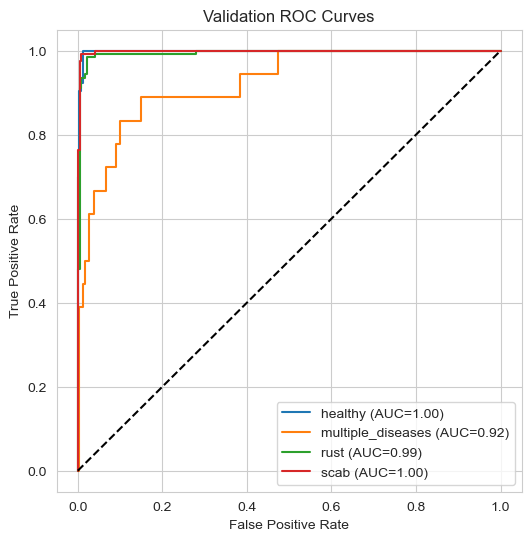

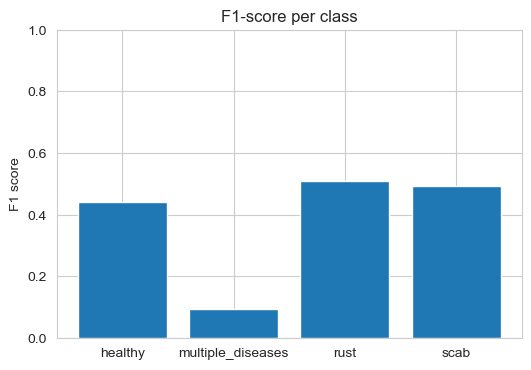

In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 重新計算驗證集預測
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs).sigmoid().cpu().numpy()
        all_preds.append(outputs)
        all_labels.append(labels.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# F1 score
preds_bin = (all_preds >= 0.5).astype(int)
macro_f1 = f1_score(all_labels, preds_bin, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")
print("\n分類報告:\n", classification_report(all_labels, preds_bin, target_names=label_cols))

# ROC curve
plt.figure(figsize=(6,6))
for i, lbl in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{lbl} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curves")
plt.legend()
plt.show()

# F1 per class bar chart
f1_per_class = f1_score(all_labels, preds_bin, average=None)
plt.figure(figsize=(6,4))
plt.bar(label_cols, f1_per_class)
plt.ylim(0,1.0)
plt.ylabel("F1 score")
plt.title("F1-score per class")
plt.show()


## 9. 結論
- 使用 EfficientNet-B3 預訓練模型可快速取得不錯的 AUC 表現。
- 可嘗試更深或更輕量的網路 (e.g. EfficientNetV2, ConvNext) 比較效能。
- 調整資料增強策略、batch size、影像輸入尺寸等，也可能提升結果。
- 若多標籤不平衡，可考慮 focal loss、class-balanced loss 或過取樣 (oversampling) 方法。
